# Digit classification model

Starting off with imports and ignoring warnings (to make things a bit tidier)

In [87]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import keras
from keras.datasets import mnist
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt

### Loading the MNIST data set
Keras comes packed with some commonly used data sets, including the MNIST handwritten digit database.

This makes it very easy to get started.

In [88]:
# from https://keras.io/datasets/#mnist-database-of-handwritten-digits
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

The next step is to convert the data set values into a form that fits our model.

This includes converting the labels into a binary class matrix, and reshaping the digit pixel values into multi dimensional arrays.

In [89]:
# from https://keras.io/getting-started/sequential-model-guide/
y_train = keras.utils.to_categorical(y_train_raw, num_classes=10, dtype="uint8")
y_test = keras.utils.to_categorical(y_test_raw, num_classes=10, dtype="uint8")

x_train = x_train_raw.reshape(60000,28,28,1)
x_test = x_test_raw.reshape(10000,28,28,1)

Below is some experimental preprocessing, which converts the grayscale images into black and white. I thought this might improve the results, but it didn't make much of a difference.

It also could have been useful since the canvas pixels on the Flask page are black and white, but I found it works best to downscale the canvas image using antialiasing, and disable this preprocessing step.

(This must be an inefficient way of doing it, because this cell takes several **minutes** to complete.)

In [90]:
def to_black_and_white(arr, threshold):
    for val in np.nditer(arr, op_flags=['readwrite']):
        if val > threshold:
            val[...] = 255
        else:
            val[...] = 0

# preprocessing step disabled for now

# to_black_and_white(x_train, 15)
# to_black_and_white(x_test, 15)

Here is how a single digit can be rendered on a graph using MatPlotLib.

Note that the pixel values are inverted, because the MNIST data set is white on a black background, while typically you would expect it to be the other way around.

'Label: 5'

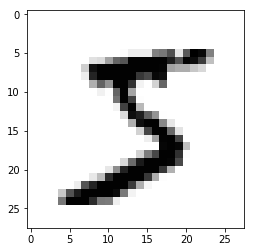

In [91]:
%matplotlib inline

plt.imshow([255 - i for i in x_train_raw[0]], cmap='gray')
"Label: {}".format(y_train_raw[0])

Here is where the model gets built. I decided to use a convolutional neural network for my model, because they perform very well for image classification problems.

I watched [this](https://youtu.be/py5byOOHZM8) video by Computerphile to learn how CNNs work.

The basic idea is that at each convolutional layer (Conv2D), a [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) is passed over the image, extracting many different features (eg. edges). Since I use two convolutional layers, a kernal is passed again over those features to produce another, smaller, set of features. During backpropagation, the neural network can figure out how the features relate to the digits 0-9, and produce a prediction.

In [92]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
# https://keras.io/layers/convolutional/
# https://keras.io/examples/mnist_cnn/
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

This trains the model.

**Epoch:** One complete pass over the training set. 10 epochs = 10 passes over the training data.

**Batch size:** Number of digits to train on the network in one go.

In [93]:
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.6487 - accuracy: 0.9137
Epoch 2/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.0952 - accuracy: 0.9711
Epoch 3/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.0699 - accuracy: 0.9786
Epoch 4/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.0579 - accuracy: 0.9819
Epoch 5/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.0527 - accuracy: 0.9838
Epoch 6/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.0484 - accuracy: 0.9847
Epoch 7/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.0443 - accuracy: 0.9857
Epoch 8/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.0412 - accuracy: 0.9875
Epoch 9/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.0379 - accuracy: 0.9884
Epoch 10/10
60000/60000 [============

Save the model to disk, to be later read back in on the Flask server.

In [94]:
# from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model.save("model.h5")

Evaluate the model on the test set.

(60,000 digits are for training, and the remaining 10,000 are for testing)

In [95]:
scores = model.evaluate(x_test, y_test)
scores

10000/10000 [==============================] - 1s 91us/step


[0.06182478961166198, 0.9828000068664551]

As a demonstration of the model, this code creates a bar chart showing the frequency of incorrect predictions produced by the model for each digit.

<Container object of 10 artists>

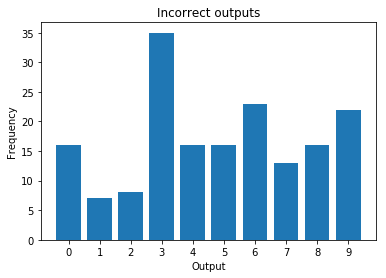

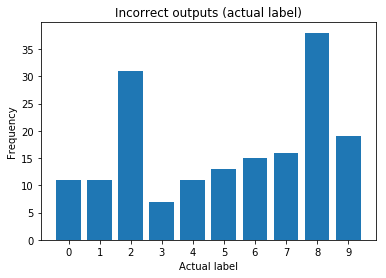

In [96]:
prediction_classes = model.predict_classes(x_test)

# initialize arrays
nums = np.arange(0, 10)
wrong_out_dist = np.zeros((10,))
wrong_out_label_dist = np.zeros((10,))

# compare predictions to actual labels
for i in range(len(prediction_classes)):
    if prediction_classes[i] != y_test_raw[i]:
        wrong_out_dist[prediction_classes[i]] += 1
        wrong_out_label_dist[y_test_raw[i]] += 1

# https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
# https://www.programcreek.com/python/example/56587/matplotlib.pyplot.title
plt.title("Incorrect outputs")
plt.xlabel("Output")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_dist, tick_label=nums)

plt.figure()
plt.title("Incorrect outputs (actual label)")
plt.xlabel("Actual label")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_label_dist, tick_label=nums)

As another demonstration, this code produces the top three digits that the model had trouble classifying.

(which should be the three most poorly drawn digits)

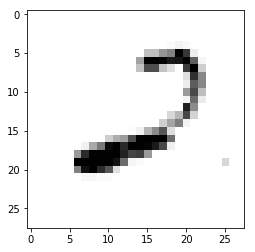

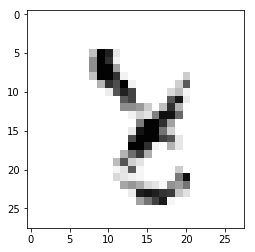

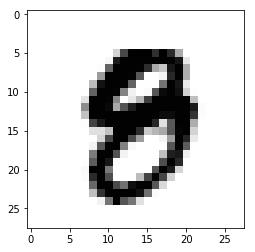

In [97]:
# get predictions for each digit in the test set
# (this differs from predict_classes, as this returns a probability distribution for each digit)
predictions = model.predict(x_test)
# get the highest prediction value for each digit (0-1 because of softmax)
confidence = [np.std(p) / max(p) for p in predictions]
# get indexes of sorted confidence values (smallest to largest)
# a small max value from a probility distribution suggests uncertainty
confidence_sorted = np.argsort(confidence)

# plot those three digits
for i in range(3):
    plt.imshow([255 - i for i in x_test_raw[confidence_sorted[i]]], cmap='gray')
    plt.show()